# Анализ данных e-commerce

## Задача

Имеются данные о покупках, соврешенных пользователями интернет магазина. Продакт менеджер просит нас исследовать эти данные и ставит нам следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз и больше не вернулись? 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

5. Провести когортный анализ пользователей. 

6. Построить RFM-сегментацию пользователей.

**Предоставленные данные:**
- `olist_customers_datase.csv` — таблица с уникальными идентификаторами пользователей
- `olist_orders_dataset.csv` —  таблица заказов
- `olist_order_items_dataset.csv` —  товарные позиции, входящие в заказы

## Этапы проекта
    
1. [Получение и предобработка данных](#1.-Получение-и-предобработка-данных)
2. [Ответы на аналитические вопросы](#2.-Ответы-на-аналитические-вопросы)
    - [Пользователи, которые совершили только одну покупку](#Пользователи,-которые-совершили-только-одну-покупку)
    - [Причины недоставки заказов](#Причины-недоставки-заказов)
    - [Популярность товаров по дням недели](#Популярность-товаров-по-дням-недели)
    - [Среднее количество покупок в неделю по пользователям](#Среднее-количество-покупок-в-неделю-по-пользователям)
3. [Когортный анализ](#3.-Когортный-анализ-пользователей)
4. [RFM сегментация пользователей](#4.-RFM-сегментация-пользователей)
5. [Итоговые выводы](#5.-Итоговые-выводы)

## 1. Получение и предобработка данных

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import timedelta
from operator import attrgetter

%matplotlib inline

In [3]:
# Настроим отображение графиков по умолчанию
sns.set_theme(style='whitegrid', 
              palette='husl',
              font_scale=1.3, 
              rc={'figure.figsize': (10, 4)}
             )

Изучим данные, предоставленные для проекта.

**Таблица с пользователями**

In [4]:
customers = pd.read_csv('olist_customers_dataset.csv')

In [5]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


 Всего в таблице 99441 строка и 5 столбцов:
 
- customer_id — позаказный идентификатор пользователя (object)

- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта) (object)

- customer_zip_code_prefix —  почтовый индекс пользователя (int64)

- customer_city —  город доставки пользователя (object)

- customer_state —  штат доставки пользователя (object)

Количество значений во всех столбцах совпадает с общих количеством строк (99441), значит пропущенные значения отсутствуют.

In [7]:
# Проведем проверку на наличие дубликатов в уникальных id пользователей в сочетании с customer_id
customers.duplicated(['customer_unique_id', 'customer_id']).sum()

0

Дубликаты отсутсвуют

In [8]:
# Посмотрим на количество уникальных городов доставки
customers.customer_city.nunique()

4119

In [9]:
# Посмотрим на количество уникальных штатов доставки
customers.customer_state.nunique()

27

**Таблица заказов**

In [10]:
orders = pd.read_csv('olist_orders_dataset.csv')

In [11]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Всего в таблице 99441 строка и 8 колонок (все типа object):

- order_id —  уникальный идентификатор заказа (номер чека)

- customer_id —  позаказный идентификатор пользователя

- order_status —  статус заказа

- order_purchase_timestamp —  время создания заказа

- order_approved_at —  время подтверждения оплаты заказа

- order_delivered_carrier_date —  время передачи заказа в логистическую службу

- order_delivered_customer_date —  время доставки заказа

- order_estimated_delivery_date —  обещанная дата доставки

Некоторые коллонки содержат информацию о дате, но имеют тип object. Приведем их к нужному формату.

In [13]:
order_dates = ['order_purchase_timestamp', 
               'order_approved_at', 
               'order_delivered_carrier_date', 
               'order_delivered_customer_date', 
               'order_estimated_delivery_date'
              ]

orders[order_dates] = orders[order_dates].apply(pd.to_datetime)

In [14]:
# Проверяем, что смена формата колонок прошла успешно
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [15]:
# Посмотрим описательную статистику
orders.describe(include='all', datetime_is_numeric=True)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,NaN,NaN,NaN,NaN,NaN
top,e26f52b2a37b0ce41ba38979221bf39d,320a107d49c46f919012be351ec06cbe,delivered,NaN,NaN,NaN,NaN,NaN
freq,1,1,96478,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800384,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542784,2018-01-24 03:08:37.730111232
min,NaN,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,NaN,NaN,NaN,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,NaN,NaN,NaN,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,NaN,NaN,NaN,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,NaN,NaN,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


В нашем распоряжении данные за промежуток между 2016-09-15 и 2018-09-03 

In [16]:
# Посмотрим на уникальные статусы заказов из столбца order_status
list(orders.order_status.unique())

['delivered',
 'invoiced',
 'shipped',
 'processing',
 'unavailable',
 'canceled',
 'created',
 'approved']

- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

In [17]:
# Проверием наличие дубликатов
orders.duplicated().sum()

0

In [18]:
# Проверям количество пропущенных значений
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Пропущенные значения имеют коллонки order_approved_at, order_delivered_carrier_date и order_delivered_customer_date. Это связано со спецификой данных, которые записываются в эти коллонки- заказ может быть отправлен, но еще не доставлен / создан, но не подтвержден. Следовательно, мы **не можем удалить или заменить** эти строки средними значениями, поэтому оставим их для дальнейшего анализа.

**Таблица с составами заказов**

In [19]:
order_items = pd.read_csv('olist_order_items_dataset.csv')

In [20]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [21]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Всего в таблице 112650 строк и 7 колонок:

- order_id —  уникальный идентификатор заказа (номер чека) (object)
- order_item_id —  идентификатор товара внутри одного заказа (int64)
- product_id —  ид товара (аналог штрихкода) (object)
- seller_id — ид производителя товара (object)
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике (object)
- price —  цена за единицу товара (float64)
- freight_value —  вес товара (float64)

Количество значений во всех столбцах совпадает с общих количеством строк (112650), значит пропущенные значения отсутствуют.

Столбец shipping_limit_date содержит информацию о максимальной дате доставки, но имеет тип object. Поменяем тип данных

In [22]:
# Меняем тип данных и проверяем резулльтат
order_items.shipping_limit_date = pd.to_datetime(order_items.shipping_limit_date)
order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [23]:
# Проверием наличие дубликатов
order_items.duplicated().sum()

0

### Выводы

Мы имеем три датасета с информацией о клиентах (customers), заказах (orders) и составе этих заказов (order_items). Датасет customers и orders связаны по ключу customer_id (позаказный идентификатор пользователя);  датасет orders и order_items связаны по ключу order_id (номер чека). 

В этом разделе мы 
- преобразовали даты из object в формат datetime; 
- проверили, что во всех 3 датасетах дубликаты отсутствуют; 
- выяснили, что данные собраны за промежуток между 2016-09-15 и 2018-09-03; 
- обнаружили пропущенные значения в датасете orders и решили их оставить, так как пропуски оказались обусловлены спецификой данных. 

Данные можно считать подготовлеными к дальнейшему анализу.

## 2. Ответы на аналитические вопросы

### Пользователи, которые совершили только одну покупку

В первую очередь, нам необходимо определить, **что считать состоявшейся покупкой**

Сформулируем гипотезу, что заврешенной покупкой можно считать оплаченный заказ. В таком случае в столбце `order_approved_at` датасета `orders` должна стоят дата подтверждения оплаты заказа, иначе заказ не был оплачен. 

Теперь небходимо выяснить заказы с каким статусом имеют нулевые значения в столбце `order_approved_at`.

In [24]:
list_status = list(orders.order_status.unique()) # вспомним возможные статусы заказов
list_status

['delivered',
 'invoiced',
 'shipped',
 'processing',
 'unavailable',
 'canceled',
 'created',
 'approved']

- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

Для каждого статуса посмотрим на наличие нулевых значений в дате подтверждения оплаты заказа 

In [25]:
# Определим ф-цию для вычисления процента заказов без подтверждения платежа 


def check_approval(status):
    nulls = orders[orders.order_status == status].order_approved_at.isnull().sum() 
    if nulls > 0:
        prc = round(nulls / orders[orders.order_status == status].order_approved_at.shape[0] * 100, 3)
        print(f'Процент неоплаченных заказов со статусом {status}: {prc}')
    else: 
        print(f'Неоплаченные заказы со стаусом {status} отсутсвуют')

In [26]:
# Применим ф-цию для каждого из возможных статусов заказов
for i in list_status:
    check_approval(i)

Процент неоплаченных заказов со статусом delivered: 0.015
Неоплаченные заказы со стаусом invoiced отсутсвуют
Неоплаченные заказы со стаусом shipped отсутсвуют
Неоплаченные заказы со стаусом processing отсутсвуют
Неоплаченные заказы со стаусом unavailable отсутсвуют
Процент неоплаченных заказов со статусом canceled: 22.56
Процент неоплаченных заказов со статусом created: 100.0
Неоплаченные заказы со стаусом approved отсутсвуют


**Вывод:** заказ может быть неоплачен при статусе 'created', 'canceled' и 'delivered' 
Скорее всего, незначительная доля неоплаченных заказов со статусом 'delivered' (менее 0.1%) связана с акциями, когда полкупатель получал товар без его оплаты, поэтому такие случае можно не учитывать. 
Следовательно, за составявшуюся покупку будем считать *заказы, которые имеют любой статус кроме 'created' и 'canceled'*.

Теперь посчитаем количество клиентов, которые совершили лишь одну покупку в нашем магазине

In [27]:
# Джоиним таблицу с закзазами с таблицей пользователей, чтобы каждому заказу соответствовал customer_unique_id
customers_orders = orders.merge(customers, on='customer_id')

In [28]:
# Отбираем состоявшиеся покупки, группируем по уникальным идентификаторам пользователей 
# и считаем количество уникальных заказов
purchaces_per_customer = (customers_orders.query('order_status not in ("cancelend", "created")')
                          .groupby('customer_unique_id', as_index=False) 
                          .agg(uniq_orders = ('order_id', 'nunique')) 
                          .sort_values('uniq_orders', ascending=False)
                         )

purchaces_per_customer.head()

,customer_unique_id,uniq_orders
52969,8d50f5eadf50201ccdcedfb9e2ac8455,17
23469,3e43e6105506432c953e165fb2acf44c,9
10353,1b6c7548a2a1f9037c1fd3ddfed95f33,7
37793,6469f99c1f9dfae7733b25662e7f1782,7
76078,ca77025e7201e3b30c44b472ff346268,7


In [29]:
# Считаем количество клиентов, соврешивших только одну покупку
num_one_pur = purchaces_per_customer.query('uniq_orders == 1').uniq_orders.sum()

# Считам процент клиентов, которые соврешили только одну покупку
prc_one_pur = round(num_one_pur / purchaces_per_customer.shape[0] * 100, 2)

print(f'{num_one_pur} ({prc_one_pur}%) клиентов совершили покупку только один раз')

93096 (96.88%) клиентов совершили покупку только один раз


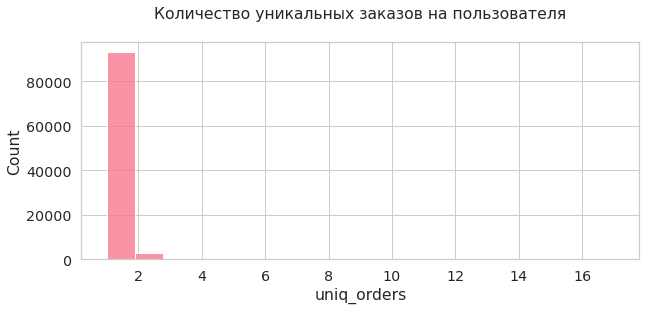

In [30]:
# Визуализируем распределение количества уникальных заказов на пользователя
sns.histplot(purchaces_per_customer.uniq_orders)
plt.title('Количество уникальных заказов на пользователя\n')
plt.show()

### Выводы

На основании статуса подтверждения платежа была решено считать за состоявшуюся покупку заказы, которые имеют статус 'invoiced', 'shipped', 'processing', 'unavailable', 'created', 'delivered' и 'approved'. 

Далее мы посчитали сколько завершенных покупок совершил каждый из клиентов. Оказалось, что огромная доля клиентов (96.88%) сделало всего лишь одну покупку в нашем магазине и больше не возвращалось. Причины такого высокого churn rate будут проанализированы позже.

### Причины недоставки заказов

На этом этапе необходимо определить сколько заказов в месяц в среднем не доставляется по разным причинам и вывести детализацию по причинам

Предположим, что недоставленным мы будем считать 2 категории заказов:

1. Товары, для которых отсутсвует информация о времени доставки, но, в соответсвии, с их статусом они должны были быть доставлены
2. Товары, которые были доставлены с опозданием более чем на 1 день

In [31]:
# Создадим колонку с временем опоздания доставки в датафрейме orders
orders['delivery_delay'] = orders.order_delivered_customer_date - orders.order_estimated_delivery_date
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8 days +21:25:13
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6 days +15:27:45
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18 days +18:06:29
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13 days +00:28:42
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10 days +18:17:02


Создаем датафрейм `failed_deliveries` с недоставленными заказами, в который, в соответствии с определенными выше критериями, попадут строки
- со значением более 1 дня в колонке `delivery_delay`  
или
- нулевым значением в колонке `order_delivered_customer_date`

In [32]:
failed_deliveries = orders.loc[(orders.order_delivered_customer_date.isnull()) | \
                               (orders.delivery_delay > pd.to_timedelta(1, 'D'))
                              ] 

failed_deliveries.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,NaT
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09 22:23:46,2017-09-28,11 days 22:23:46
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,delivered,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-03-21 22:03:54,2018-03-12,9 days 22:03:54
41,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,7 days 18:59:23
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,NaT


In [33]:
# Посмотрим какие статусы имели недоставленные заказы
failed_deliveries_status = (failed_deliveries.groupby('order_status', as_index=False)
                            .size()
                            .sort_values('size', ascending=False)
                           )
failed_deliveries_status

,order_status,size
3,delivered,6542
6,shipped,1107
1,canceled,620
7,unavailable,609
4,invoiced,314
5,processing,301
2,created,5
0,approved,2


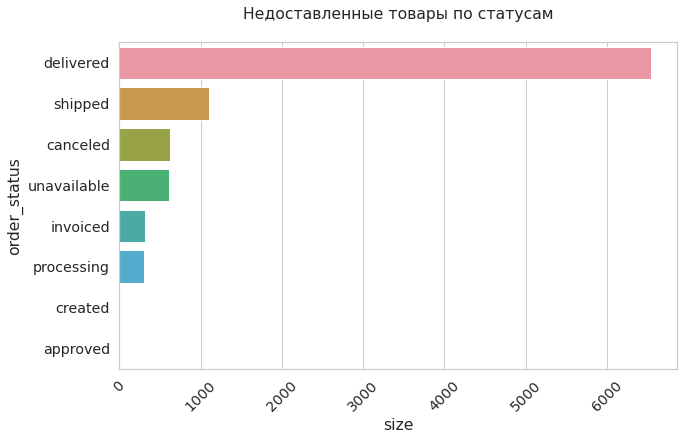

In [34]:
# Визуализируем результат
plt.figure(figsize=(10, 6))
sns.barplot(data=failed_deliveries_status, y='order_status', x='size')
plt.xticks(rotation=45)
plt.title('Недоставленные товары по статусам\n')
plt.show()

Для дальнейшего анализа нас интересуют только заказы со стаусом 'delivered' *(заказы, которые были доставлены, но опооздали более чем на 1 день)*, 'canceled' *(заказы, которые были недоставлены из-за отмены покупателем или магазином)* и 'unavailable' *(заказы, которые были недоставлены из-за потери)*. 

Заказы с другими статусами попали в таблицу из-за их естественных особенностей- например, заказы со статусом 'shipped' были отправлены, но еще недоставлены, поэтому они имеют нулевое значение в колонке 
'order_delivered_customer_date'; а заказы со стасуом 'invoiced', 'processing', 'created' и 'approved' и вовсе еще не были отправлены.

In [35]:
# Оставляем в недоставленных заказы со статусом 'delivered', 'canceled' и 'unavailable'
failed_deliveries = failed_deliveries.query("order_status in ('delivered', 'canceled', 'unavailable')")
failed_deliveries.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09 22:23:46,2017-09-28,11 days 22:23:46
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,delivered,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-03-21 22:03:54,2018-03-12,9 days 22:03:54
41,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,7 days 18:59:23
57,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,delivered,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03 13:28:46,2018-04-02,1 days 13:28:46
58,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-04-06 13:37:16,2017-03-30,7 days 13:37:16


Для того, чтобы посчитать статистику по месяцам, необходимо привести даты к началу месяца

In [36]:
# Приведем даты в колонке 'order_estimated_delivery_date' к началу месяца
failed_deliveries['order_estimated_delivery_date'] = (failed_deliveries['order_estimated_delivery_date']
                                                        .dt.strftime('%Y-%m')
                                                       )
failed_deliveries.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09 22:23:46,2017-09,11 days 22:23:46
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,delivered,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-03-21 22:03:54,2018-03,9 days 22:03:54
41,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12,7 days 18:59:23
57,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,delivered,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03 13:28:46,2018-04,1 days 13:28:46
58,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-04-06 13:37:16,2017-03,7 days 13:37:16


In [37]:
# Cгруппируемся по статусу заказа (причина недоставки) и месяцу
failed_deliveries_gr = (failed_deliveries.groupby(['order_status',  'order_estimated_delivery_date'],
                                                  as_index=False
                                                 )
                        .size()
                       )
failed_deliveries_gr.head()

,order_status,order_estimated_delivery_date,size
0,canceled,2016-09,1
1,canceled,2016-10,3
2,canceled,2016-11,10
3,canceled,2016-12,7
4,canceled,2017-02,2


Создадим график изменения количества недоставленных заказов по разным причинам

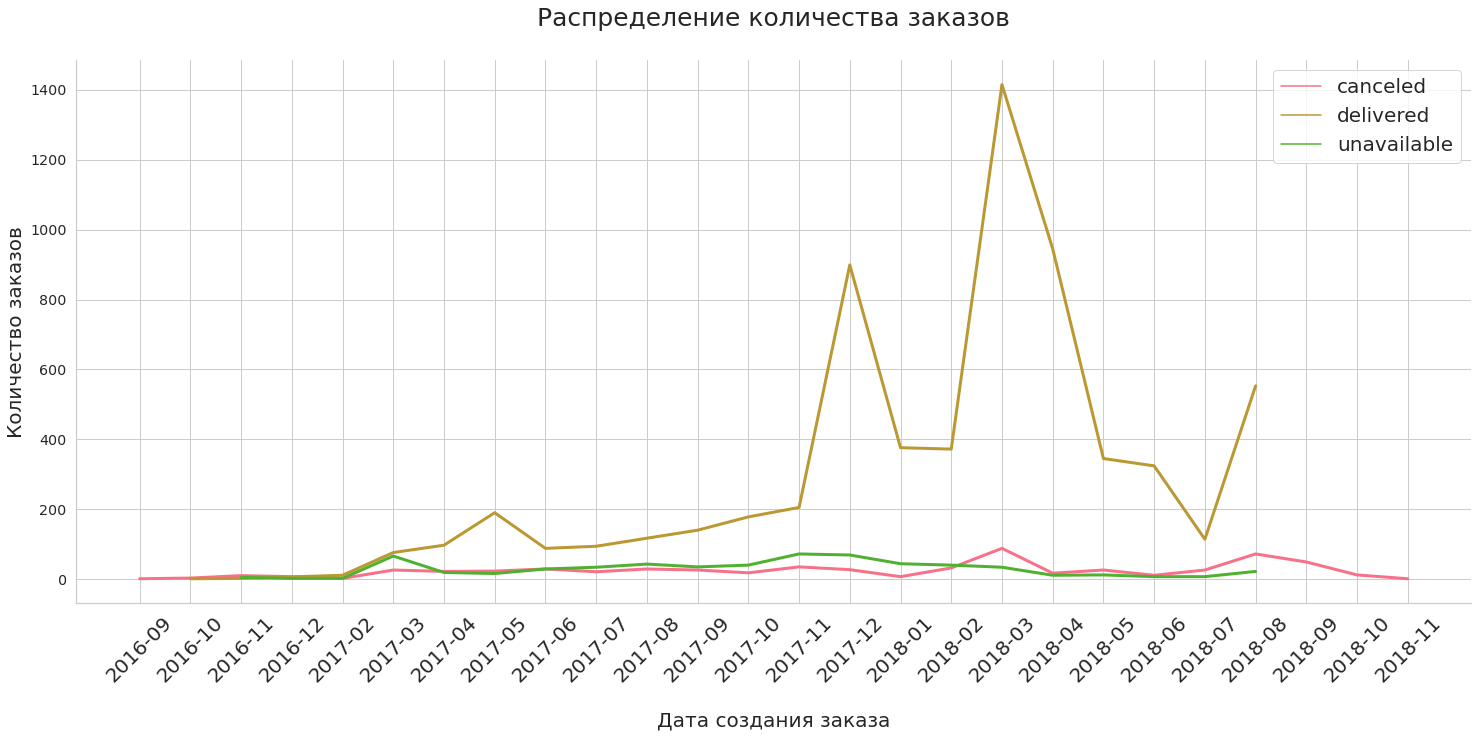

In [38]:
plt.figure(figsize=(25, 10))

sns.lineplot(data=failed_deliveries_gr, x='order_estimated_delivery_date', y='size', hue='order_status', lw=3)

plt.xticks(rotation=45, size=20)
plt.title('Распределение количества заказов\n', fontsize=25)
plt.xlabel('\nДата создания заказа', fontsize=20)
plt.ylabel('Количество заказов', fontsize=20)
plt.legend(fontsize=20)
plt.grid
sns.despine()
plt.show()

По графику видно, что, во-первых, гораздо больше заказов опаздывает, чем не доставляется вообще, во-вторых, есть месяца, в которых по каким-то причинам, заказы опаздывали гораздо чаще, чем в другие.

In [39]:
# Cделаем сводную таблицу из полученных данных
failed_deliveries_piv = (failed_deliveries_gr.pivot(columns='order_status', 
                                                    index='order_estimated_delivery_date', 
                                                    values='size'
                                                   )
                         .fillna(0)
                        )

failed_deliveries_piv.head()

order_status,canceled,delivered,unavailable
order_estimated_delivery_date,,,
2016-09,1.0,0.0,0.0
2016-10,3.0,1.0,0.0
2016-11,10.0,2.0,5.0
2016-12,7.0,0.0,2.0
2017-02,2.0,11.0,2.0


In [40]:
# На основании полученной сводной таблицыосчитаем сколько заказов в месяц в среднем не доставляется
# по разным причинам 
failed_deliveries_piv_m = failed_deliveries_piv.mean().sort_values(ascending=False)
failed_deliveries_piv_m

order_status
delivered      251.615385
canceled        23.846154
unavailable     23.423077
dtype: float64

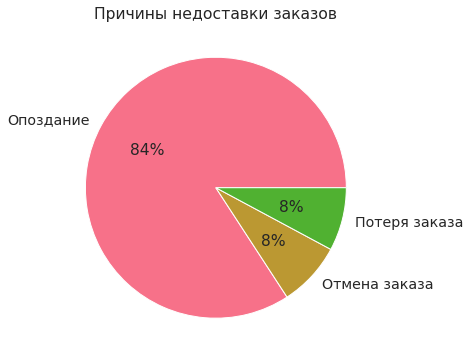

In [41]:
# Визуализируем долю недоставленных заказов по различным причинам
plt.figure(figsize=(10, 6))
plt.pie(x=failed_deliveries_piv_m, 
        labels = ['Опоздание', 'Отмена заказа', 'Потеря заказа'], 
        autopct='%.0f%%')
plt.title('Причины недоставки заказов')
plt.show()

Теперь хотелось бы понять насколько велика **ежемесячная доля недоставленных заказов**. Для этого найдем среднее число заказов в месяц и разделим на количество сбоев доставки по разным причинам.

In [42]:
# Создадим отдельную колонку с месяцами доставки
orders['month'] = orders.order_estimated_delivery_date.dt.to_period('M')
# Сгрупирумся по месяцам и посчитаем среднее количество заказов в месяц
m_ord_month = orders.groupby('month', as_index=False).size().mean().values
# Удалим созданную колонку, так как она не пригодится для будущего анализа
orders.drop('month', axis=1, inplace=True)

Разделим среднемесячное количество недоставленных товаров по разным причинам на среднемесячное количество заказов, чтобы получить долю



In [43]:
pd.DataFrame(failed_deliveries_piv_m / m_ord_month * 100)

,0
order_status,
delivered,6.831805
canceled,0.647465
unavailable,0.635978


В итоге видно, что около 7% заказов в месяц приходят с опозданием, по причине потери или отмены недоставляется всего по 0.6% заказов

### Выводы

Самая частая причина того, что клиент не получает товар в назначенное время - опоздание доставки более чем на 1 день. В среднем около 251 заказа в месяц (84% из всех недоствавленных заказов) приходят с опозданием. При этом из-зам отмены и потери недоставляется в среднем всего 23 и 24 товара в месяц соответственно. 

В целом, можно говорить, что служба доставки работает удовлетворительно, так как всего лишь около 7% заказов в месяц опаздывает к покупателю, а доля потерянных заказов составляет менее 1%. Однако, стоит обратить внимание на то, что в были периоды, когда заказы опаздывали гораздо чаще среднего. Стоит выяснить что было причиной таких проблем с доставкой и постараться устранить их на будущее. 

### Популярность товаров по дням недели

На этом этапе необходимо по каждому товару определить, в какой день недели товар чаще всего покупается

In [44]:
# Создадим колонку, в которую запишем день недели, в который был куплен товар
orders.insert(4, 'order_day_of_week', orders.order_purchase_timestamp.dt.day_name())
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_day_of_week,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,Monday,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8 days +21:25:13
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,Tuesday,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6 days +15:27:45
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,Wednesday,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18 days +18:06:29
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,Saturday,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13 days +00:28:42
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,Tuesday,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10 days +18:17:02


Информация о составе товаров для каждого заказа содержится в датафрейме `order_items`. Таблицы `orders` и `order_items` связаны по ключу  'order_id'

In [45]:
# Джойним таблицу заказов с информацией о товарах, входящих в заказы
orders_and_items = orders.merge(order_items, on='order_id')
orders_and_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_day_of_week,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,Monday,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8 days +21:25:13,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,Tuesday,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6 days +15:27:45,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,Wednesday,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18 days +18:06:29,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,Saturday,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13 days +00:28:42,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,Tuesday,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10 days +18:17:02,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [46]:
# Создаем сводную таблицу с данными о количестве заказов по дням недели для каждого товара
orders_and_items_pivot = orders_and_items.pivot_table(index   = 'product_id', 
                                                      columns = 'order_day_of_week', 
                                                      aggfunc = 'size')
orders_and_items_pivot.head()

order_day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,NaN,NaN,NaN,1.0,NaN,NaN,NaN
00088930e925c41fd95ebfe695fd2655,NaN,NaN,NaN,NaN,NaN,1.0,NaN
0009406fd7479715e4bef61dd91f2462,NaN,NaN,NaN,NaN,1.0,NaN,NaN
000b8f95fcb9e0096488278317764d19,1.0,NaN,NaN,NaN,NaN,NaN,1.0
000d9be29b5207b54e86aa1b1ac54872,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [47]:
# Создадим датафрейм, в котором каждому товару будет соответствовать день недели, в который он чаще всего покупается
most_pop_day = pd.DataFrame(orders_and_items_pivot.apply('idxmax', axis=1), columns=['day_of_week'])
most_pop_day.head()

,day_of_week
product_id,
00066f42aeeb9f3007548bb9d3f33c38,Sunday
00088930e925c41fd95ebfe695fd2655,Tuesday
0009406fd7479715e4bef61dd91f2462,Thursday
000b8f95fcb9e0096488278317764d19,Friday
000d9be29b5207b54e86aa1b1ac54872,Tuesday


Визуализируем распределение количества покупок всех товаров по дням недели

In [48]:
# Подготовим данные для визуализации

product_by_weekname = (orders_and_items.groupby(['product_id', 'order_day_of_week'], as_index=False) 
                       .order_item_id
                       .count()
                       .sort_values('order_item_id', ascending=False)
                      )

product_by_weekname_plot = (product_by_weekname.reset_index().groupby('order_day_of_week')
                            .order_item_id.count()
                            .reset_index()
                            .sort_values('order_item_id')
                           )

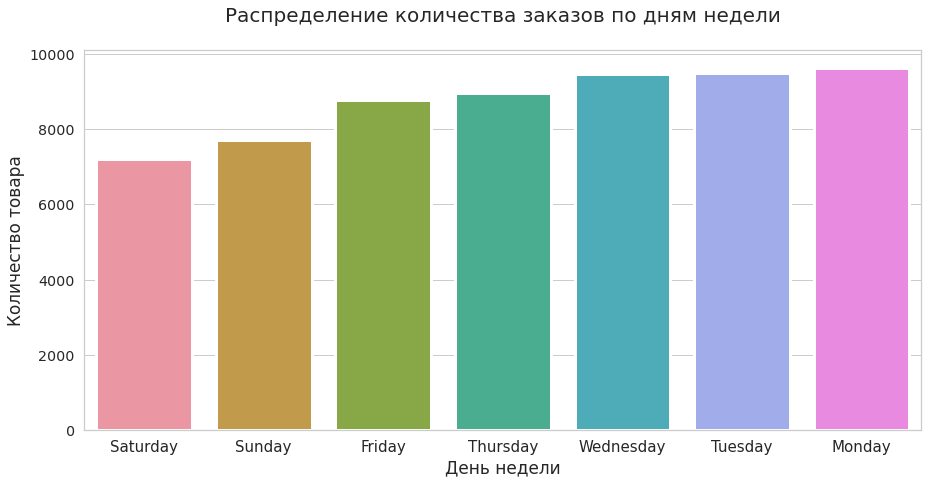

In [49]:
plt.figure(figsize=(15, 7))
ax=sns.barplot(data=product_by_weekname_plot, x='order_day_of_week', y='order_item_id', lw=3)
plt.xticks(size=15)
plt.title('Распределение количества заказов по дням недели\n', fontsize=20)
plt.xlabel('День недели', fontsize=17)
plt.ylabel('Количество товара', fontsize=17)
plt.show()

По графику видно, что на выходных у нас делают немного меньше заказов, чем в будние дни

### Выводы

Мы выполнили задачу продакта - получили таблицу, в которой каждому товару соответсвует день недели, в который он чаще всего покупается. Данная таблица будет полезна для дальнейшего анализа сезонности продаж по различным категория продуктов.  
В субботу и воскресение заказы в нашем магазине немного проседают  
Так как у нас есть только информация об обезличенном id продукта и мы не знаем его категорию и наименование, мы не можем получить больше полезной информации из имеющихся данных.

### Среднее количество покупок в неделю по пользователям

На этом этапе нам ставиться задача  посчитать сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

Алгоритм решения задачи:

1. Объеденить данные о пользователях с данными об их покупках
2. Отобрать только успешные покупка
3. Сгупировать данные по пользователям и месяцам
4. Посчитать количество покупок за месяц для каждого пользователя
5. Получить точное количество недель для каждого месяца
6. Разделить количество покупок пользователя за месяц на количество недель в этом месяце

Информация об уникальных пользователях содержится в таблице `customers`, a информация об их покупках в таблице `orders`. Таблицы связаны по ключу 'customer_id'

In [50]:
# Джойним таблицу с данными о польозвателях и таблицу заказов
customers_and_orders = customers.merge(orders, on='customer_id')
customers_and_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_day_of_week,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,Tuesday,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,-11 days +10:35:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,Friday,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,-8 days +12:41:19
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,Saturday,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1 days 17:58:51
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,Tuesday,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,-13 days +16:04:25
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,Sunday,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,-6 days +20:55:48


Ранее мы решили, что за составявшуюся покупку будем считать заказы, которые имеют любой статус кроме 'created' и 'canceled', поэтому сначала необходимо отобрать эти покупки

In [51]:
# Отбираем только успешные заказы
customers_and_orders = customers_and_orders.query('order_status not in ("cancelend", "created")')
customers_and_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_day_of_week,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,Tuesday,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,-11 days +10:35:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,Friday,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,-8 days +12:41:19
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,Saturday,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1 days 17:58:51
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,Tuesday,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,-13 days +16:04:25
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,Sunday,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,-6 days +20:55:48


Так как мы хотим получить статистику по месяцам, нам необходим привести даты покупок к формату YYYY-MM

In [52]:
# Приведем даты покупок к формату YYYY-MM
customers_and_orders['order_purchase_timestamp'] = (customers_and_orders['order_purchase_timestamp']
                                                    .dt 
                                                    .strftime('%Y-%m')
                                                   )
customers_and_orders['order_purchase_timestamp'].head() # проверямем результат

0    2017-05
1    2018-01
2    2018-05
3    2018-03
4    2018-07
Name: order_purchase_timestamp, dtype: object

In [53]:
# Сгруппируем данные по пользователям и месяцам и посчитаем количество их покупок
customers_and_orders_gr = customers_and_orders.groupby(['customer_unique_id', 'order_purchase_timestamp'], 
                                                       as_index=False
                                                      ).size().sort_values('size', ascending=False)
customers_and_orders_gr.head()

,customer_unique_id,order_purchase_timestamp,size
7324,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6
62191,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4
50617,83e7958a94bd7f74a9414d8782f87628,2017-01,4
69391,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4
23939,3e43e6105506432c953e165fb2acf44c,2018-02,4


Чтобы получить точное количество недель в каждом месяце, сначала получим количество дней в месяце при помощи атрибута dt.daysinmonth и разделим это число на 7

In [54]:
# Получим точное количество недель в каждом месяце
customers_and_orders_gr['weeks_in_month'] =  (pd.to_datetime(customers_and_orders['order_purchase_timestamp'])
                                              .dt.daysinmonth / 7
                                             )
                                              
customers_and_orders_gr.head()

,customer_unique_id,order_purchase_timestamp,size,weeks_in_month
7324,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,4.000000
62191,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,4.428571
50617,83e7958a94bd7f74a9414d8782f87628,2017-01,4,4.428571
69391,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,4.428571
23939,3e43e6105506432c953e165fb2acf44c,2018-02,4,4.285714


In [55]:
# Посчитаем среднее количество покупок в неделю по пользователям (по месяцам)
customers_and_orders_gr['avg_buys_per_week'] = (round(customers_and_orders_gr['size'] /
                                                customers_and_orders_gr['weeks_in_month'], 2)
                                               )
customers_and_orders_gr.head()

,customer_unique_id,order_purchase_timestamp,size,weeks_in_month,avg_buys_per_week
7324,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,4.000000,1.50
62191,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,4.428571,0.90
50617,83e7958a94bd7f74a9414d8782f87628,2017-01,4,4.428571,0.90
69391,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,4.428571,0.90
23939,3e43e6105506432c953e165fb2acf44c,2018-02,4,4.285714,0.93


In [56]:
# Приведем к более удобному формату, сделав id пользователей и даты индексами
customers_and_orders_gr.set_index(['customer_unique_id', 'order_purchase_timestamp'], drop=True, inplace=True)
customers_and_orders_gr.sort_values('customer_unique_id').head()

,,size,weeks_in_month,avg_buys_per_week
customer_unique_id,order_purchase_timestamp,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571,0.23
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571,0.23
0000f46a3911fa3c0805444483337064,2017-03,1,4.428571,0.23
0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571,0.23
0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.428571,0.23


Посмотирм сколько у нас пользователей, которые делают в среднем 2 и более заказа в неделю

In [57]:
mean_orders = len(customers_and_orders_gr.query('avg_buys_per_week >= 2'))
print('Количество пользователей, у которых в среднем в неделю 2 и более заказа:', mean_orders)

Количество пользователей, у которых в среднем в неделю 2 и более заказа: 0


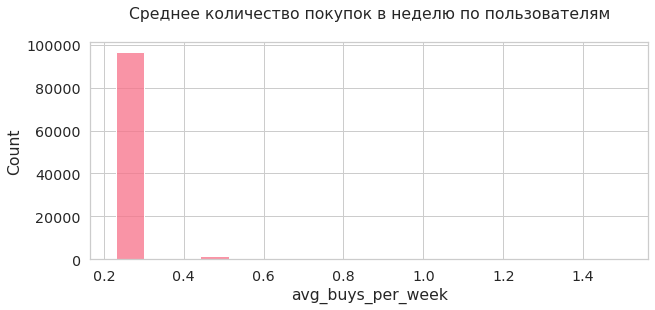

In [58]:
# Посмотрим на расрпределение среднего количества покупок в неделю
sns.histplot(customers_and_orders_gr.avg_buys_per_week)
plt.title('Среднее количество покупок в неделю по пользователям\n')
plt.show()

Похоже, что большинство пользователей в среднем делало на нашей площадке 0.23 покупок в неделю (1 покупка) и ниодин пользователь не делает даже 2 покупки в неделю. 

Визуализируем распределение среднего количества заказов в неделю по месяцам. 

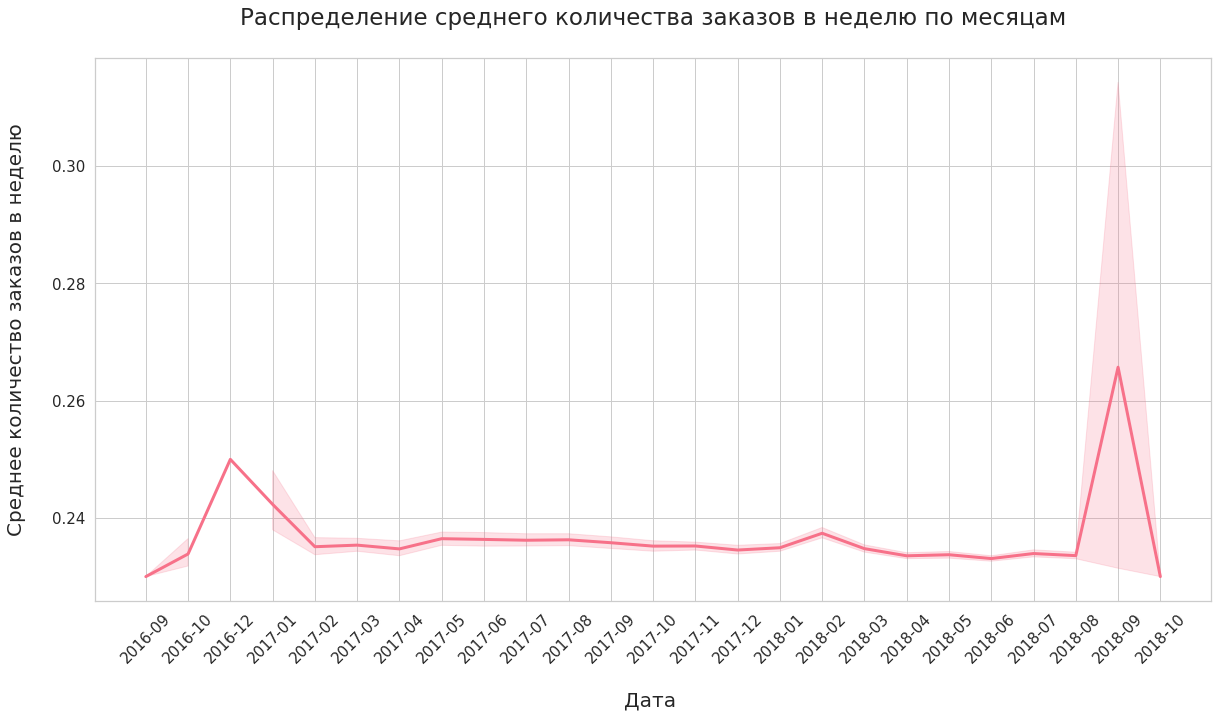

In [59]:
plt.figure(figsize=(20, 10))

ax=sns.lineplot(data=customers_and_orders_gr.sort_values('order_purchase_timestamp'),
                x='order_purchase_timestamp', 
                y='avg_buys_per_week', lw=3)

plt.xticks(rotation=45, size=15)
plt.yticks(size=15)
plt.title('Распределение среднего количества заказов в неделю по месяцам\n', fontsize=23)
plt.xlabel('\nДата ', fontsize=20)
plt.ylabel('Среднее количество заказов в неделю\n', fontsize=20)
plt.show()

По графику видно, что все периоды среднее количество заказов в неделю остается стабильно низкми. Небольшие скачки в феврале и 2017 и 2018 годов обусловлены, скорее, меньшим количеством недель в месяце, чем реальным увеличением покупательской активности.  
Однако, также бросается в глаза резкий подъем в августе 2018. В предыдущий год август ничем не выделялся, поэтому предположение о сезонности отметается. Чтобы это могло быть?

### Выводы

Мы выполнили задание продакт-менеджера -  получили датафрейм со средним количество покупок покупок в неделю для каждого пользователя по месяцам. 

Оказалось, что большинство пользователей в среднем делает 0.23 покупки в неделю, тоесть 1 покупку в неделю (1/4.43). У такого результата могут быть различные причины:
- наш продукт монетизируется по подписочной модели и минимальный период подписки составляет более 1 недели
- мы торгуем продуктами длительного пользования, срок жизни которых превышает 1 неделю 
- имеется проблема в продукте/сервисе, которая не позволяет нам удерживать клиентов, и они просто не возвращаются после первой покупки

## 3. Когортный анализ пользователей

На данном этапе нам необходимо провести когортный анализ пользователей и изучить retention rate клиентов, которые начали пользоваться нашим сервисом в разное время.

**Суть когортного анализа** — объединение клиентов (пользователей, посетителей) в группы по одинаковым характеристикам или атрибутам и отслеживание их поведения во времени.
Описание подхода можно найти [тут](https://vc.ru/s/productstar/134090-chto-takoe-kogortnyy-analiz).

Подготовим данные

In [60]:
# Джойним таблицы пользователей и заказов 
customers_orders_ = orders.merge(customers, on='customer_id')

Разделим пользователей на когорты по месяца - пользователи, совершившие свою первую покупку в один месяц, формируют когорту.

Чтобы учесть все возможные сезонные эффекты, будем анализировать период в один целый календарный год. Для того, чтобы получить статистику пользователей, которые пришли в конце 2017 года, захватим также информацию за часть 2018 года. В итоге берем срез данных с января 2017 по март 2018 года.

In [61]:
# Отберем только успешные заказы в период с января 2017 по март 2018 года

start = pd.to_datetime('2017-01')  # начало периода
finish =  pd.to_datetime('2018-04')  # конец периода

customers_orders_ = customers_orders_.query("(order_status not in ('cancelend', 'created')) & \
                                             (order_purchase_timestamp >= @start) & \
                                             (order_purchase_timestamp < @finish)"
                                            )
                    
customers_orders_.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_day_of_week,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,Monday,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8 days +21:25:13,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,Saturday,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13 days +00:28:42,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,Tuesday,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10 days +18:17:02,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,Sunday,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,-6 days +10:57:55,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,Tuesday,2017-04-13 13:25:17,NaT,NaT,2017-05-09,NaT,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS


Оставим только нужные колонки - id пользователей и даты покупок

In [62]:
customers_orders_ = customers_orders_[['customer_unique_id', 'order_purchase_timestamp']]
customers_orders_.head()

,customer_unique_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 21:57:05
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-11 12:22:08


Создадаим колонку `cohort`, в которую запишем дату первой покупки для каждого пользователя, и колонку `order_month`, в которую запишем месяц покупки для каждого заказа

In [63]:
customers_orders_['cohort'] = (customers_orders_.groupby('customer_unique_id')
                               .order_purchase_timestamp  
                               .transform('min') 
                               .dt.to_period('M')
                              )

customers_orders_['order_month'] = customers_orders_.order_purchase_timestamp.dt.to_period('M')

customers_orders_.head()

,customer_unique_id,order_purchase_timestamp,cohort,order_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-09,2017-10
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,2018-02
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 21:57:05,2017-07,2017-07
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-11 12:22:08,2017-04,2017-04


На следующем шаге оставим только информацию о когорте пользователя, дате заказа и посчитаем количество уникальных клиентов в каждый месяц по когортам

In [64]:
cohort = (customers_orders_.groupby(['cohort', 'order_month'], as_index=False) 
          .agg(n_customers=('customer_unique_id', 'nunique'))
         )
cohort.head()

,cohort,order_month,n_customers
0,2017-01,2017-01,765
1,2017-01,2017-02,3
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3


Добавим столбец с номером периода для кажджого месяца когорты

In [65]:
cohort['n_period'] = (cohort.order_month - cohort.cohort).apply(attrgetter('n'))
cohort.head()

,cohort,order_month,n_customers,n_period
0,2017-01,2017-01,765,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4


Создадим сводную таблицу поместив номер когорты в индексы, количество прошедших периодов в колонки, а в количество уникальных пользователей в значения 

In [66]:
cohort_piv = cohort.pivot(index='cohort', columns='n_period', values='n_customers')
cohort_piv

n_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort,,,,,,,,,,,,,,,
2017-01,765.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,NaN,NaN
2017-04,2353.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN
2017-07,3895.0,20.0,14.0,10.0,11.0,8.0,12.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4184.0,29.0,14.0,11.0,15.0,22.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4131.0,28.0,22.0,12.0,19.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Осталось поделить каждую ячейку на изначальный размер когорты, чтобы получить retention rate в процентах

In [67]:
retention = cohort_piv.divide(cohort_piv.iloc[:, 0], axis=0)
retention

n_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort,,,,,,,,,,,,,,,
2017-01,1.0,0.003922,0.002614,0.001307,0.003922,0.001307,0.005229,0.001307,0.001307,NaN,0.003922,0.001307,0.007843,0.003922,0.001307
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,NaN,NaN
2017-04,1.0,0.005950,0.002125,0.001700,0.003400,0.002550,0.003400,0.002975,0.002975,0.001700,0.002550,0.000850,NaN,NaN,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,NaN,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005135,0.003594,0.002567,0.002824,0.002054,0.003081,0.001027,0.001797,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006931,0.003346,0.002629,0.003585,0.005258,0.002868,0.002629,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006778,0.005326,0.002905,0.004599,0.002179,0.002179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Заменим отсутствующее значение нулем 
retention.iloc[0, 9] = 0

Визуализируем результат на графике

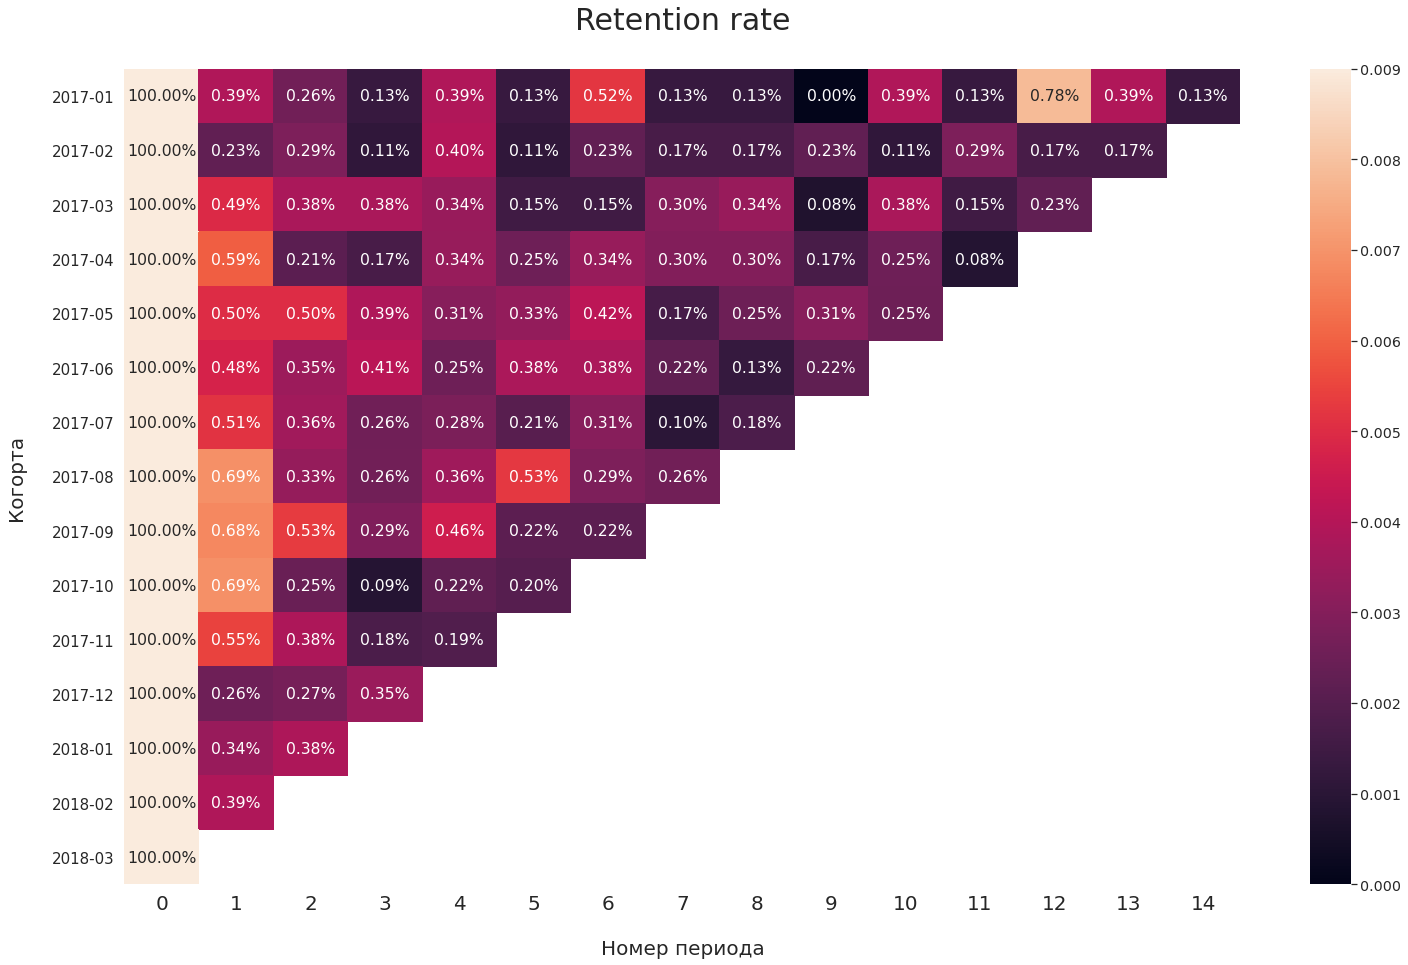

In [69]:
plt.figure(figsize=(25, 15))

sns.heatmap(retention, mask=retention.isnull(), annot=True, fmt='.2%', vmin=0.0, vmax=0.009)

plt.title('Retention rate\n', size=30)
plt.xlabel('\nНомер периода', fontsize=20)
plt.ylabel('Когорта\n', fontsize=20)
plt.yticks(size=15)
plt.xticks(size=20)
plt.show()

In [70]:
# Посчитаем средний retention для всех когорт за период
print(f'Средний retention {round(retention.mean()[1:].mean() * 100, 2)}%')

Средний retention 0.27%


Retention rate у всех групп подозрительно низкий. Посмотрим какой процента пользователей вообще делал повторные покупки, чтобы убедиться, что наш результат не ошибка.

In [71]:
a = round((customers.customer_unique_id.count() - 
           customers.customer_unique_id.nunique()) /
           customers.customer_unique_id.count() * 100, 1
         )

print(f'За весь период всего {a}% пользователей совершили повторные покупки')

За весь период всего 3.4% пользователей совершили повторные покупки


### Выводы



Мы провели когортный анализ Retention rate пользователей, которые пришли в наш сервис с 01.2017 по 03.2018. Всего мы проанализировали 14 групп пользователей. 

Retention rate для всех когорт оказался крайне низким- между 0 и 0.8% со средним по всем периодам и группам 0.27%.
Такой результат вполне оправдан и ожидаем, учитывая, что всего 3.4% пользователей нашего сервиса совершают повторные покупки. Как мы предполагали выше у такой статистики могут быть различные причины: подписочная модель монетизации с долгим периодом продления; наш бизнес торгует товарами длительного пользования, которые не предполагают скорой замены; или все таки проблема в нашем сервисе, который не позволяет нам удерживать аудиторию. 

## 4. RFM сегментация пользователей

**Суть RFM-анализа** в том, что мы разделяем всех пользователей на группы, в зависимости от того, 1) как давно они сделали последнюю покупку, 2) как часто покупали и 3) насколько большой была сумма их заказов

Аббревиатура RFM расшифровывается:

- Recency — давность (как давно ваши пользователи что-то у вас покупали);
- Frequency — частота (как часто они у вас покупают);
- Monetary — деньги (общая сумма покупок).

 Чтобы получить RFM рейтинг пользователя, нам нужно оценить их R, F и M по шкале от 1 (худший) до 3 (лучший).
 
**Этапы:**

0. Подготовить данные
1. Посчитать Recency- количество дней с последний покупки
2. Посчитать Freqency - количество покупок за исследуемый период
3. Посчитать Monetary - количество покупок за исследуемый период
4. Определить границы каждой статистики для присвоения оценки
4. Присвоить оценку каждой статистике в зависимости от того в каких границах она находится
5. Соединить R, F и M оценки, чтобы получить RFM рейтинг
6. Соотнести RFM рейтинг с сегментами пользователей

**Подготовим данные**

In [72]:
# Джойним все таблицы
merged = customers.merge(orders, on='customer_id').merge(order_items, on='order_id')
# Отбираем успешные покупки
merged = merged.query("order_status not in ('cancelend', 'created')")
# Оставляем только нужные коллонки
merged = merged[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'price']]
merged.head()

,customer_unique_id,order_id,order_purchase_timestamp,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,230.00


In [73]:
# Группируем заказы, и складываем итоговую цену
merged_gr = (merged.groupby(['customer_unique_id', 'order_id', 'order_purchase_timestamp'], as_index=False) 
             .price.sum() 
            )
merged_gr.head()

,customer_unique_id,order_id,order_purchase_timestamp,price
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.90
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,25.99
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,180.00


In [74]:
# Проверяем, что группировка прошла успешно и заказы не задвоились
print(f'Колличество уникальных заказов в изначальной таблице: {merged.order_id.nunique()}')
print(f'Колличество заказов после группировки и сложения цен отдельных товаров: {merged_gr.order_id.count()}')

Колличество уникальных заказов в изначальной таблице: 98666
Колличество заказов после группировки и сложения цен отдельных товаров: 98666


**Посчитаем метрики Recency, Freqency и Monetary для каждого пользователя**

In [75]:
# В качестве текущей даты берем самую позднюю дату покупки + 1 день
present = merged_gr.order_purchase_timestamp.max() + timedelta(days=1)
present

Timestamp('2018-09-04 09:06:57')

Создаем датафрейм с данными для RFM анализа

- Для recency считаем количество дней между текущей датой и датой последней покупки
- Для frequency считаем количество заказов для каждого покупателя
- Для monetary считаем сумму покупок для каждого покупателя

In [76]:
%%time

rfm = merged_gr.groupby('customer_unique_id').agg(recency   =  ('order_purchase_timestamp', 
                                                  lambda date: (present - date.max()).days),
                                                  frequency = ('order_id', lambda num: len(num)), 
                                                  monetary  = ('price', lambda price: price.sum()))
rfm.head()

CPU times: user 25.9 s, sys: 286 ms, total: 26.2 s
Wall time: 25.9 s


,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
0000f46a3911fa3c0805444483337064,542,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
0004aac84e0df4da2b147fca70cf8255,293,1,180.00


In [77]:
# Меням формат коллонки recency
rfm['recency'] = rfm['recency'].astype(int)

**Определим границы каждой статистики для присвоения оценки**

Посмотрим на параметры статистик, которые мы получили

In [78]:
rfm.describe()

,recency,frequency,monetary
count,95420.000000,95420.000000,95420.000000
mean,243.600377,1.034018,142.440198
std,153.160320,0.211234,217.656355
min,1.000000,1.000000,0.850000
25%,119.000000,1.000000,47.900000
50%,224.000000,1.000000,89.900000
75%,353.000000,1.000000,155.000000
max,729.000000,16.000000,13440.000000


Посмотрим на распределения статистики **recency**

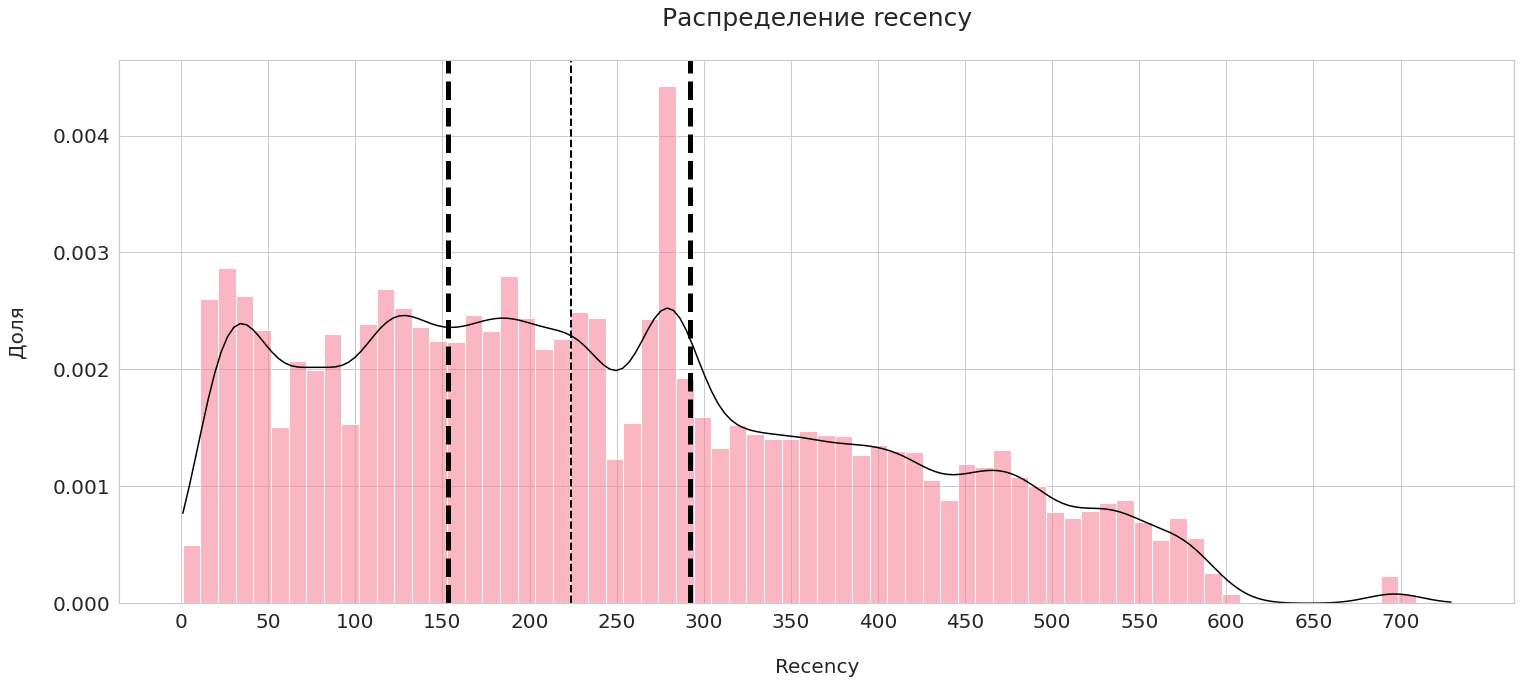

In [79]:
plt.figure(figsize=(25, 10))

ax = sns.histplot(rfm.recency, kde=True, stat='density')
ax.lines[0].set_color('black')
ax.set_xticks(range(0, 750, 50))

plt.axvline(x=rfm.recency.median(), color='black', ls='--', lw=2)  # отсечка на медиане
plt.axvline(x=rfm.recency.quantile(q=0.33), color='black', ls='--', lw=5)  # отсечка на 33 перцентиле
plt.axvline(x=rfm.recency.quantile(q=0.66), color='black', ls='--', lw=5)  # отсечка на 66 перцентиле

plt.title('Распределение recency\n', size=25)
plt.xlabel('\nRecency', fontsize=20)
plt.ylabel('Доля\n', fontsize=20)
plt.yticks(size=20)
plt.xticks(size=20)

plt.show()

Размах статистики recency достаточно большой и распределение не критично скошено в какую-либо из сторон, поэтому допустимо разделить всех пользователей на 3 группы по 33 и 66 перцентилю

Посмотрим на распределение статистики **frequency**

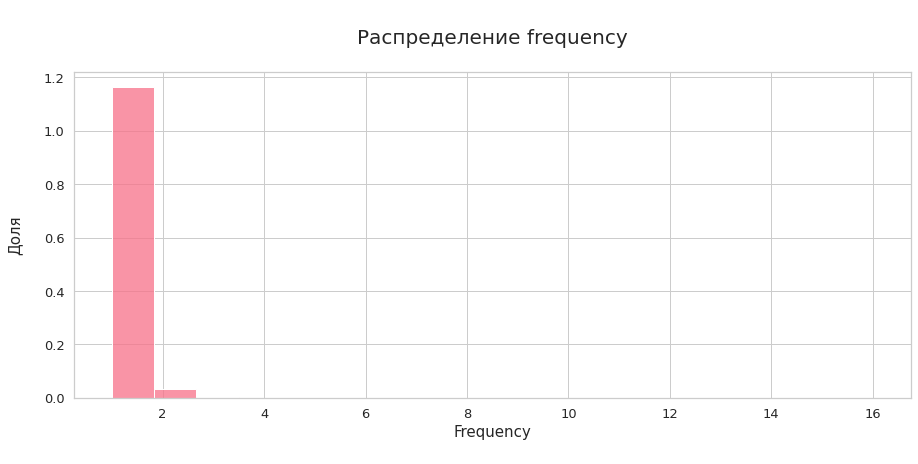

In [80]:
plt.figure(figsize=(15, 6))
    
ax = sns.histplot(rfm.frequency, stat='density')

plt.title('\nРаспределение frequency\n', size=20)
plt.yticks(size=13)
plt.xticks(size=13)
plt.xlabel('Frequency\n', fontsize=15)
plt.ylabel('Доля\n', fontsize=15)

plt.show()

In [81]:
rfm.frequency.value_counts().to_frame()

,frequency
1,92507
2,2673
3,192
4,29
5,9
6,5
7,3
16,1
9,1


Как и следовало ожидать, принимая во внимания все, что мы узнали о наших данных ранее, большинство покупателей у нас совершили только одну покупку, таких покупателей будем добавлять в один сегмент. Есть небольшое количество пользователей, которые совершили до четрых заказов, единицы совершили пять и более заказов, поэтому разделим frequency на три сегмента: 1 заказ, 2-4 заказа, более 5 заказов.

Посмотрим на распределение статистики **monetary**

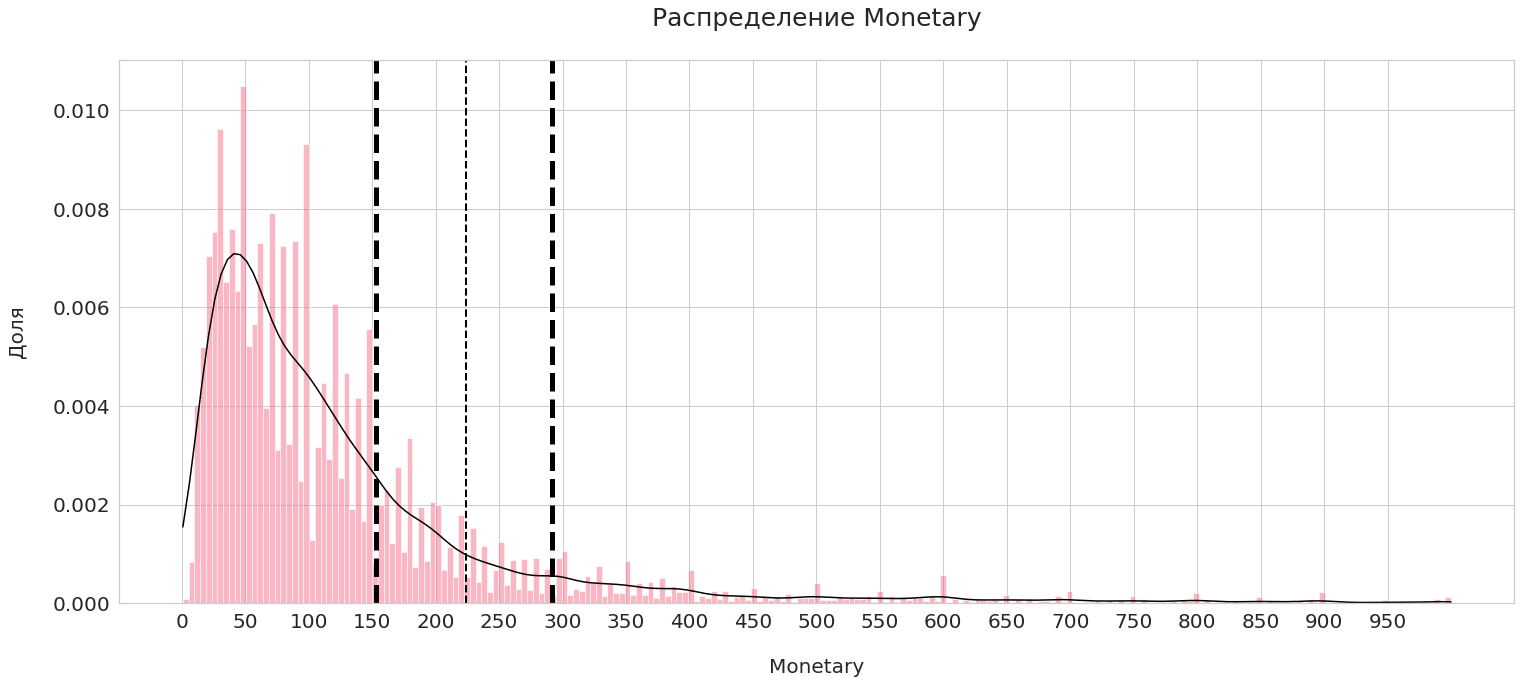

In [82]:
plt.figure(figsize=(25, 10))

ax = sns.histplot(rfm.monetary.loc[rfm.monetary <= 1000], kde=True, stat='density')  # отрежем выбросы более 1000
ax.lines[0].set_color('black')
ax.set_xticks(range(0, 1000, 50))

plt.axvline(x=rfm.recency.median(), color='black', ls='--', lw=2)
plt.axvline(x=rfm.recency.quantile(q=0.33), color='black', ls='--', lw=5)
plt.axvline(x=rfm.recency.quantile(q=0.66), color='black', ls='--', lw=5)

plt.title('Распределение Monetary\n', size=25)
plt.xlabel('\nMonetary', fontsize=20)
plt.ylabel('Доля\n', fontsize=20)
plt.yticks(size=20)
plt.xticks(size=20)

plt.show()

Статистика monetary имеет значительный размах и имеет достаточно наблюдений на каждом промежутке 0 - 33 перцентиль - 66 перцентиль, поэтому допустимо разделить всех пользователей на 3 группы по 33 и 66 перцентилю.

Вычислим точные границы статистик monetary и recency для присвоения оценок

In [83]:
quintiles = rfm[['recency', 'monetary']].quantile([.33, .66])
quintiles['frequency'] = [1, 4]
quintiles = quintiles.to_dict()
quintiles

{'recency': {0.33: 153.0, 0.66: 292.0},
 'monetary': {0.33: 57.99, 0.66: 125.0},
 'frequency': {0.33: 1, 0.66: 4}}

Границы каждой статистики для присвоения оценки:
 
**Recency**
- Сегмент 3 - дата последней покупки меньше 153 дней назад (постоянный)
- Сегмент 2 - дата последней покупки больше 153, но меньше 292 дней назад (спящий)
- Сегмент 1 - дата последней покупки больше 292 дней (уходящий)

**Frequency**
- Сегмент 3 - покупал больше 5 раз
- Сегмент 2 - покупал от 2 до 4 раз
- Сегмент 1 - покупал 1 раз

**Monetary**
- Сегмент 3 - покупки от 125
- Сегмент 2 - покупки от 58 до 125
- Сегмент 1 - покупки меньше, чем 57.99

**Присвоим оценку каждой из статистик**

In [84]:
# ф-ция для присвоения оценки recency (чем меньше, тем выше оценка)
def r_score(x):
    if x <= quintiles['recency'][.33]:
        return 3
    elif x <= quintiles['recency'][.66]:
        return 2
    else:
        return 1
    

# ф-ция для присвоения оценки frquency и monetary (чем больше, тем выше оценка)
def fm_score(x, column):
    if x <= quintiles[column][.33]:
        return 1
    elif x <= quintiles[column][.66]:
        return 2
    else:
        return 3

In [85]:
# Применяем ф-ции
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['M'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

**Соединим R, F и M оценки, чтобы получить RFM рейтинг**

In [86]:
rfm['RFM'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)
rfm.head()

,recency,frequency,monetary,R,F,M,RFM
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,3,313
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311
0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,3,113


**Соотнесем RFM рейтинг с сегментами пользователей**

Всего у нас может быть 3^3 = 27 различных сегментов. С таким количеством групп достатоно сложно работать, поэтому для удобтсва мы разделим всех наших пользователей на 8 сегментов:

- **Потерянные** - давно делали одну покпку на небольшую сумму
- **Одноразовые** - давно делали одну покпку на среднюю сумму
- **Уходящие** - сделали несколько покупок, а потом перестали покупать
- **Нельзя потерять** - уходящие клиенты, которые делали много больших покупок
- **Спящие разовые** - покупали не так давно один раз
- **Спящие** - покупали не так давно и по несколько раз
- **Новички** - недавно соврешили первую покупку
- **Постоянные** - сделали много покупок

In [87]:
# Создадим словарь в котором ключи- RFM рейтинг, а значения- RFM сегменты
segt_map = {r'111': 'Потерянные',
            r'11[2-3]': 'Одноразовые',
            r'12[1-3]': 'Уходящие',
            r'13[1-3]': 'Нельзя потерять',
            r'21[1-3]': 'Спящие разовые',
            r'2[2-3][1-3]': 'Спящие',
            r'31[1-3]': 'Новички', 
            r'3[1-3][1-3]': 'Постоянные'
           }

# Создадим новую колонку, в которую запишем RFM сегмент пользователя
rfm['Segment'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,recency,frequency,monetary,R,F,M,RFM,Segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,3,313,Новички
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311,Новички
0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112,Одноразовые
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,Потерянные
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,3,113,Одноразовые


Визуализируем распределение покупателей по сегментам

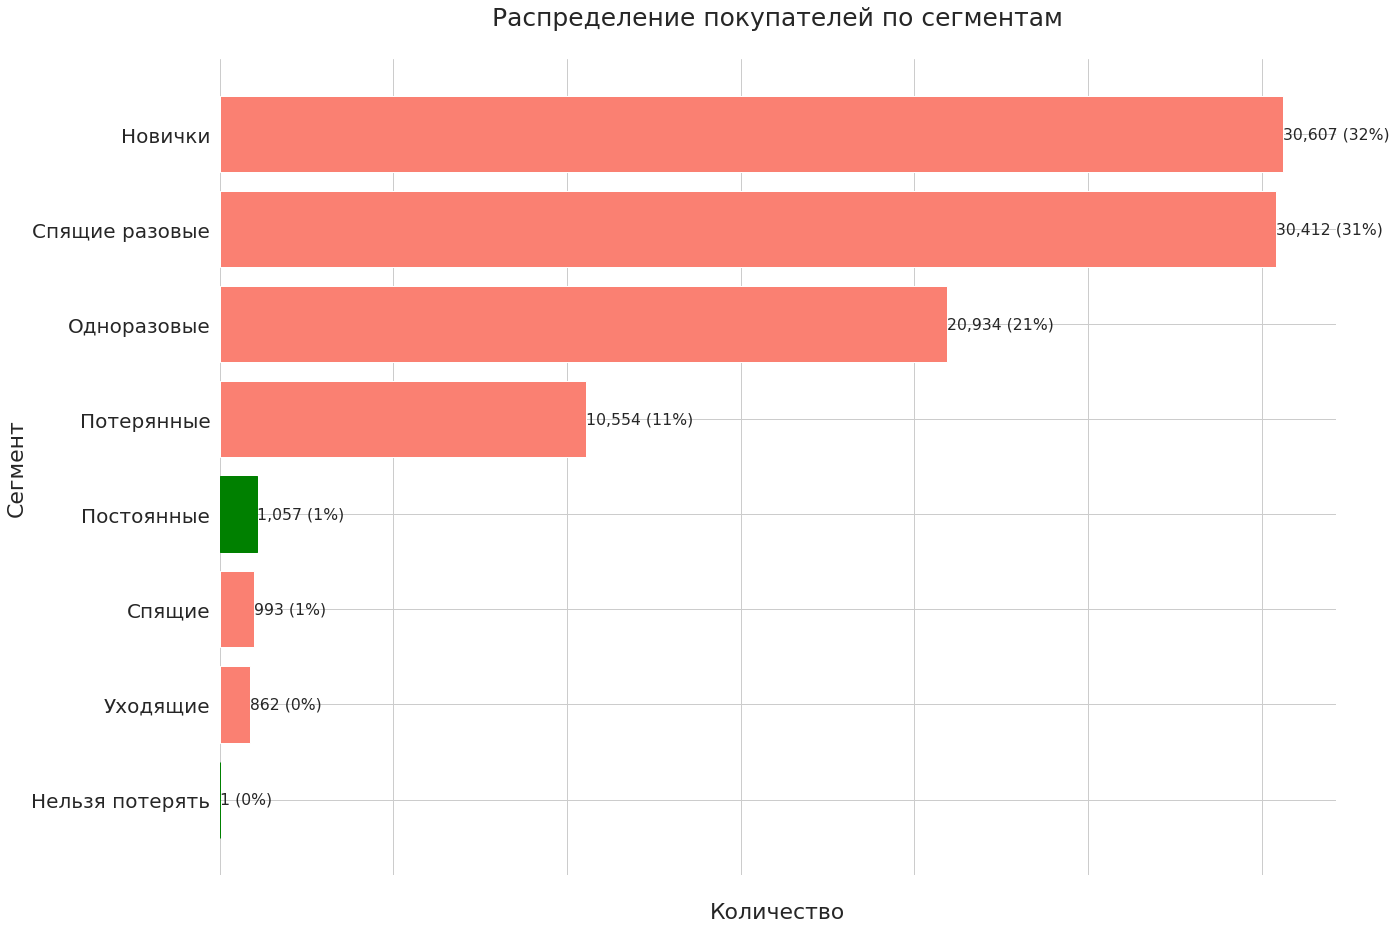

In [89]:
# Посчитаем количество покупателей в каждом сегменте
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)


# Построим барплот
fig, ax = plt.subplots(figsize=(20, 15))
ax.set_frame_on(False)
bars = ax.barh(range(len(segments_counts)), segments_counts, color='salmon')
ax.tick_params(left=False, bottom=False, labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

# Настроим отображение 
for i, bar in enumerate(bars): 
        value = bar.get_width()
        if segments_counts.index[i] in ('Постоянные', 'Нельзя потерять'):
            bar.set_color('green')  # подсветим наиболее ценные сегменты покупателей
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value), 
                                     int(value*100/segments_counts.sum())
                                    ),  
                va='center',
                ha='left'
               )  # отображаем абсолютное и процентное количество покупателей в сегменте
        
plt.title('Распределение покупателей по сегментам\n', size=25)
plt.xlabel('\nКоличество', fontsize=22)
plt.ylabel('Сегмент', fontsize=22)
plt.yticks(size=20)
plt.xticks(size=20)

plt.show()

### Выводы и рекомендации

Большинство клиентов наших клиентов относится к одному из 4 RFM сегментов: новички (недавно совершили свою первую покупку), спящие разовые (не так давно сделали одну покупку), одноразовые (давно делали одну покпку на среднюю сумму) и потерянные (давно делали одну покпку на небольшую сумму). К каждому из оставшихся сегментов относится до 1% клиентов. 

В целом, такое распределение ожидаемо, так как ранее мы выяснили, что большинство клиентов делает в нашем сервисе всего 1 покупку, следовательно, они попадают в сегменты с frequency = 1 (новички, спящие разовые, одноразовые и потерянные).

Результат сегментации позволит нам  более персонифицировано работать с клиентами. Вот какие действия по отношению к каждой из групп можно предложить:

- *потерянные* - скорее всего, эти клиенты уже ушли от нас, и не стоит тратить слишком больших усилий на этот сегмент
- *спящие разовые* - эти клиенты ещё помнят о нас. Нужно попробовать расшевелить их стимулирующими акциями. Можно отправить им рассылки с интересными акциями и выгодными предложениями
- *одноразовые* - этих клиентов можно попытаться вернуть и обязательно получить обратную связь, почему они от нас ушли. Можно отправить реактивационную рассылку с опросом
- *новички* - этим клиентом можно отправить welcome письмо с описанием преимуществ, ответами на частые вопросы, обучающие материалы, в доплонение можем отправить им интересное предложение, чтобы удержать интерес
- *постоянные* - наши самые хорошие клиенты, можно попробовать увеличить сумму чека, отправив им специальные предложения, сопутствующие товары или вообще не утомлять их лишними рассылками, раз они и так хорошо покупают

## 5. Итоговые выводы

- Прежде всего мы определили **что считать состоявшейся покупкой**. Так как было обнаружено, что заказ может быть неоплачен при статусе 'created' и 'canceled', было решено, что за составявшуюся покупку будет считаться заказ, который имеют любой статус кроме 'created' и 'canceled'
- Далее мы посчитали пользователей с одной покупкой. Оказалось, что огромная доля клиентов (96.88%) сделало всего лишь одну покупку в нашем магазине и больше не возвращалось. Этот факт имел большое влияние на весь последующий анализ
- После мы исследовали **причины недоставки товара**. Было решено, что недоставленным считается не только заказы, которые имеют статус canceled или unavailable, но также те, которые не были доставллены клиенту в назначенный день, хоть и были получены позже. В итоге, именно опоздание доставки было самой частой (84% от всех сбоев в доставке) причиной неполучения заказа. Также на этом шаге мы выяснили, что при относительно небольшой доли опоздавших заказов (около 7% заказов в месяц опаздывало) были месяца, в которых служба доставки не справлялась с потоком и гораздо чаще нарушала сроки
- Следующей задачей было составить таблицу, в которой каждому товару соответсвует **день недели, в который он чаще всего покупается**. Полученная таблица может быть полезна для дальнейшего анализа продуктов. На этом шаге мы также выяснили, что на выходных у нас делают меньше заказов, чем в будние дни
- Далее нам ставилась задача получить датафрейм со **средним количество покупок покупок в неделю для каждого пользователя по месяцам**. Оказалось, что большинство пользователей в среднем делает 0.23 покупки в неделю, тоесть 1 покупку в неделю (1/4.43). В этом разделе мы также сделали предположения относительно причин такого результата
- Следующим этапом было исследование **retention rate пользователей по когортам**. Для анализа мы брали 14 когорт 01.2017 по 03.2018. По итогу retention rate для всех когорт оказался крайне низким- между 0 и 0.8% со средним по всем периодам и группам 0.27%. Мы ожидали подобный результат, так как знали заранее, что лишь маленькая доля пользователей совершала в нашем сервисе больше одной покупки
- Последним этапом было проведение **RFM сегментации пользователей**. Мы определили оптимальные для наших данных границы для оценки каждой RFM статистики, присвоили всем пользователям RFM рейтинг и разделили их на 8 различных сегментов. По результатам RFM анализы были даны рекомендации по работе с каждым из сегментов пользователей